In [226]:
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib

In [227]:
# Load the trained model
model = tf.keras.models.load_model(
    'lstm_model64.keras'
)

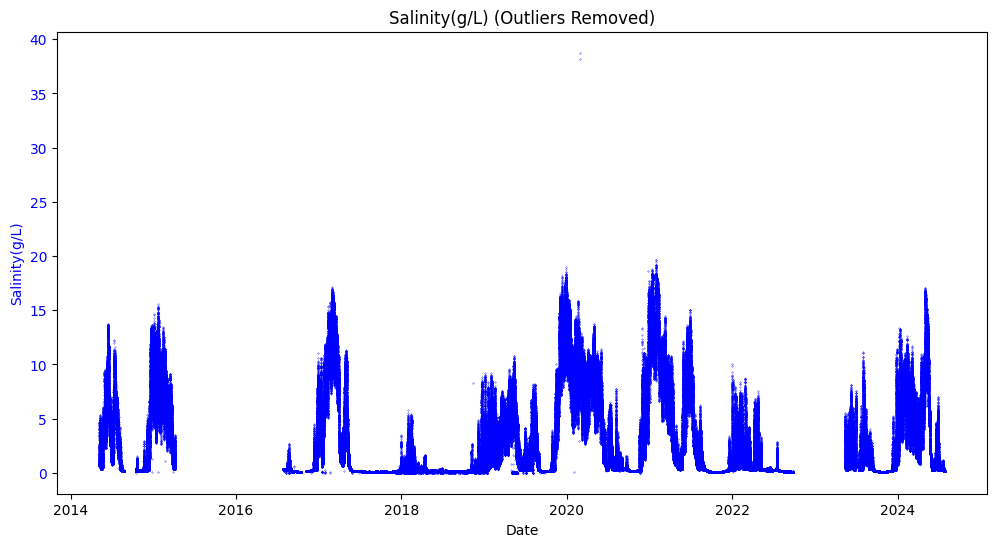

In [228]:
# Load the data
csv_file = '/Users/ratchanonkhongsawi/Desktop/CMKL/SELF-Learn/RND1/Data/unclean_csv/ladpo.csv'
df = pd.read_csv(csv_file)

# Convert date_time to datetime format and set as the index
df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')
df.set_index('date_time', inplace=True)

# Filter for columns 'Salinity(g/L)' and 'Sensor_Depth' and remove rows with NaN values
df = df.loc[: , ['Salinity(g/L)']].dropna()

# Remove outliers in Sensor_Depth (e.g., values above 55, assuming they're erroneous)
df = df[(df['Salinity(g/L)'] > 0) & (df['Salinity(g/L)'] < 55)]

# Plot both columns
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Salinity(g/L) data
ax1.plot(df.index, df['Salinity(g/L)'], '.', markersize=0.5, label='Salinity(g/L)', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Salinity(g/L)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Title and show plot
plt.title('Salinity(g/L) (Outliers Removed)')
plt.show()

In [229]:
# Rename the column to match the column name during fitting
df = df.rename(columns={'Salinity(g/L)': 'Salinity'})
# Load the preprocessing parameters
preprocessing_params = joblib.load('lstm64_preprocessing_params.pkl')

# Extract the saved scaler, train_mean, and train_std
scaler = preprocessing_params['scaler']
train_mean = preprocessing_params['train_mean']
train_std = preprocessing_params['train_std']

# Suppose you have some new data to preprocess (e.g., new_df)
# 1. Transform the data using the saved scaler
new_df_scaled = scaler.transform(df)

# 2. Apply log1p transformation (if you did it before)
new_df_log = np.log1p(new_df_scaled)

# 3. Normalize using the saved train_mean and train_std
new_df_normalized = (new_df_log - train_mean) / train_std

# Convert back to a DataFrame if desired
df_normalized = pd.DataFrame(new_df_normalized, columns=['Salinity(g/L)'])

# Now new_df_normalized is preprocessed consistently with your original training data.

In [230]:
# Rename the column to match the column name during fitting
df = df.rename(columns={'Salinity':'Salinity(g/L)'})

In [231]:
true_values = df['Salinity(g/L)'].values

In [232]:
# Make predictions
predictions = model.predict(df_normalized)

12567/12567 ━━━━━━━━━━━━━━━━━━━━ 3s 255us/step


In [233]:
# Import the MeanAbsoluteError class
mae_metric = tf.keras.losses.MeanAbsoluteError()

# Calculate MAE
mae = mae_metric(df_normalized, predictions).numpy()
print(f"Mean Absolute Error (normalize): {mae:.4f}")

Mean Absolute Error (normalize): 0.0261


In [234]:
print(predictions.shape)

(402122, 1, 1)


In [235]:
# Force reshape to (n_samples, 1)
predictions = predictions.reshape(-1, 1)

In [236]:
# Step 1: Denormalize (reverse Z-score)
predictions = (predictions * train_std) + train_mean

# Step 2: Reverse log1p
predictions = np.expm1(predictions)

# Step 3: Inverse scaling
predictions = scaler.inverse_transform(predictions)

In [237]:
print("Predictions range:", predictions.min(), predictions.max())
print("True values range:", df['Salinity(g/L)'].min(), df['Salinity(g/L)'].max())

Predictions range: 0.12245243 34.86944
True values range: 0.01 38.76


In [238]:
# Calculate MAE (denormalize)
mae = mae_metric(df['Salinity(g/L)'], predictions).numpy()
print(f"Mean Absolute Error (normalize): {mae:.4f}")

Mean Absolute Error (normalize): 0.1047


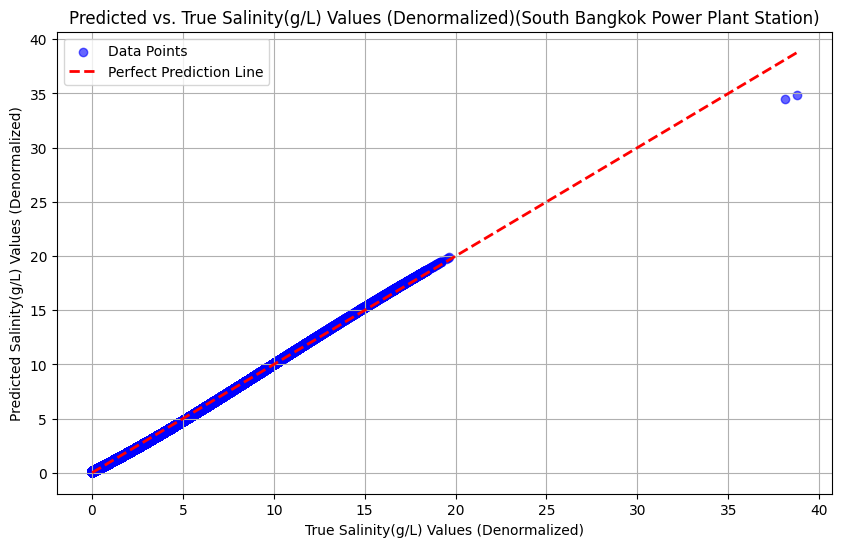

In [239]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Salinity(g/L)'], predictions, alpha=0.6, color='blue', label='Data Points')
plt.plot([df['Salinity(g/L)'].min(), df['Salinity(g/L)'].max()],
         [df['Salinity(g/L)'].min(), df['Salinity(g/L)'].max()], 'r--', linewidth=2, label='Perfect Prediction Line')
plt.xlabel('True Salinity(g/L) Values (Denormalized)')
plt.ylabel('Predicted Salinity(g/L) Values (Denormalized)')
plt.title('Predicted vs. True Salinity(g/L) Values (Denormalized)(South Bangkok Power Plant Station)')
plt.legend()
plt.grid(True)
plt.show()

In [240]:
print("Min of denormalized predictions:", predictions.min())
print("Max of denormalized predictions:", predictions.max())
print("Min of true values:", df['Salinity(g/L)'].min())
print("Max of true values:", df['Salinity(g/L)'].max())

Min of denormalized predictions: 0.12245243
Max of denormalized predictions: 34.86944
Min of true values: 0.01
Max of true values: 38.76


In [241]:
print("Shape of denormalized_predictions:", predictions.shape)
print("Shape of denormalized_df['Salinity(g/L)']:", df['Salinity(g/L)'].shape)

Shape of denormalized_predictions: (402122, 1)
Shape of denormalized_df['Salinity(g/L)']: (402122,)


In [242]:
predictions = predictions.reshape(-1)  # Now predictions is (46154,)

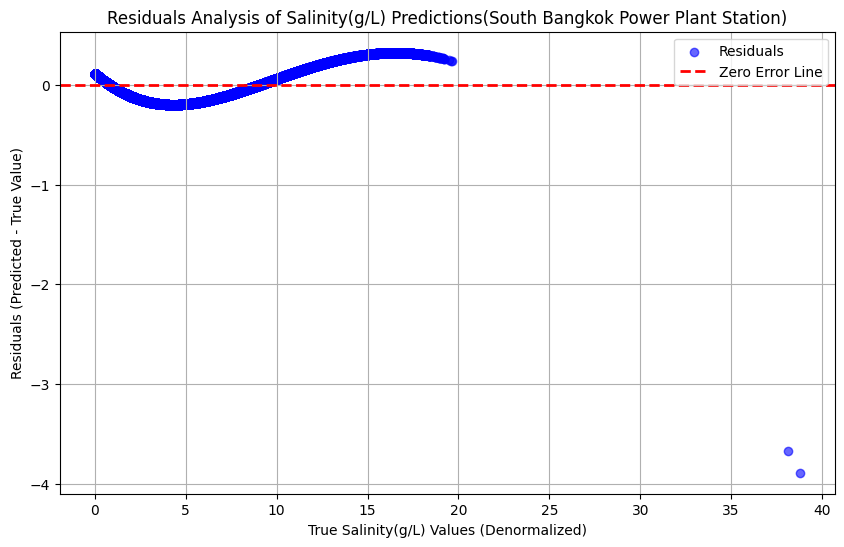

In [243]:
# Calculate residuals (errors)
residuals = predictions - true_values

plt.figure(figsize=(10, 6))
plt.scatter(true_values, residuals, alpha=0.6, color='blue', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error Line')
plt.xlabel('True Salinity(g/L) Values (Denormalized)')
plt.ylabel('Residuals (Predicted - True Value)')
plt.title('Residuals Analysis of Salinity(g/L) Predictions(South Bangkok Power Plant Station)')
plt.legend()
plt.grid(True)
plt.show()

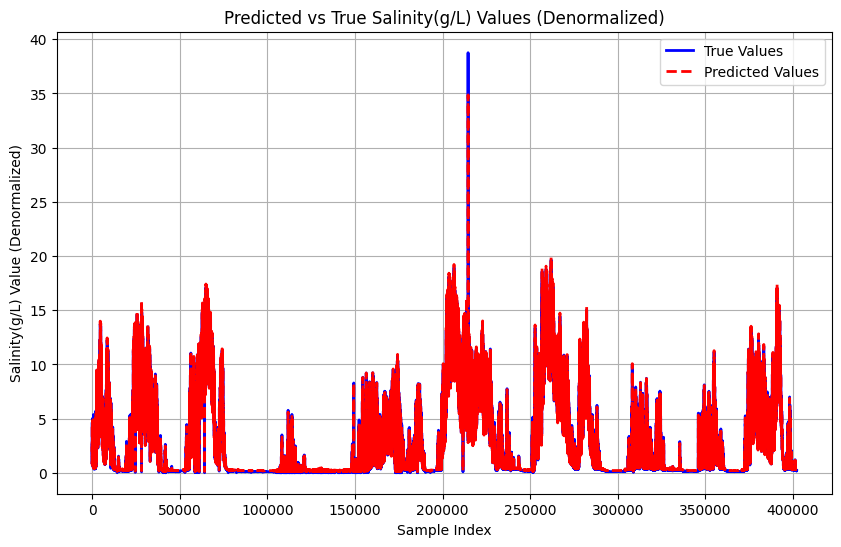

In [244]:
# Plot Predicted vs True Salinity(g/L) Values
plt.figure(figsize=(10, 6))
plt.plot(true_values, label='True Values', color='blue', linewidth=2)
plt.plot(predictions, label='Predicted Values', color='red', linestyle='--', linewidth=2)
plt.xlabel('Sample Index')
plt.ylabel('Salinity(g/L) Value (Denormalized)')
plt.title('Predicted vs True Salinity(g/L) Values (Denormalized)')
plt.legend()
plt.grid(True)
plt.show()